# 47-prediction-sprint4

> Train MLP model on 2015-2018-Aug data, test on 2018-Sept data, predict 2018-Nov by 2018-Oct

> Including grid search

In [35]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import os

## Gridsearch

In [36]:
seed=114514
test_size=0.25

### Rebalancing Samples

Due to the imbalanced data, we manually overrepresent the purchases and underrepresent the non-purchases.

In [43]:
new_data = pd.read_csv("/data/p_dsi/teams2022/team_1/fe_data1/2015_18_08.csv")
new_data = new_data.fillna(-1)
X = new_data.drop('response',axis=1)
Y = new_data['response']
X_train_old, X_test_old, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state = seed)
train = pd.concat([X_train_old, Y_train], axis=1)
length = 2*len(train[train['response']==1])
buy = train[train['response']==1].sample(n=length, replace=True, random_state = seed)
nobuy = train[train['response']==0].sample(n=length, replace=True, random_state = seed)
new_train = pd.concat([buy,nobuy])
X_train = new_train.drop(['indiv_id','response'], axis=1)
Y_train = new_train['response']
X_test = X_test_old.drop(['indiv_id'], axis = 1)

In [44]:
mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(31,50,10),(31,),(31,60),(31,80),(31,50,20)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05, 0.001, 0.005, 0.0005],
    'learning_rate': ['adaptive'],
}
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train, Y_train) # X is train samples and y is the corresponding labels

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['relu'],
                         'alpha': [0.0001, 0.05, 0.001, 0.005, 0.0005],
                         'hidden_layer_sizes': [(31, 50, 10), (31,), (31, 60),
                                                (31, 80), (31, 50, 20)],
                         'learning_rate': ['adaptive'], 'solver': ['adam']})

In [45]:
clf.best_params_

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (31, 50, 20),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

In [46]:
Y_prob = pd.DataFrame(clf.predict_proba(X_test), columns = ['pred_0', 'pred_1'])
Y_pred = clf.predict(X_test)
print("model predict")
Real_X = pd.read_csv("/data/p_dsi/teams2022/team_1/fe_data1/2015_18_09.csv")
Real_X = Real_X.fillna(-1)
Real_Y_prob = pd.DataFrame(clf.predict_proba(Real_X.drop(['indiv_id', 'response'], axis=1)), columns = ['pred_0', 'pred_1'])
top100k_id_new = pd.concat([Real_X, Real_Y_prob], axis=1).sort_values('pred_1', ascending=False)['indiv_id'].unique()[0:100000]
Real_Y = pd.read_csv("/data/p_dsi/teams2022/team_1/new_data/20181031.csv")
Real_Y_id = Real_Y[Real_Y['prod_group_code']==5]['indiv_id'].unique()
index = len([x for x in top100k_id_new if x in Real_Y_id])/100000
print("index:", index)

model predict
index: 0.10977


## Prediction based on GS

In [47]:
Real_X = pd.read_csv("/data/p_dsi/teams2022/team_1/fe_data1/2015_18_10.csv")
Real_X = Real_X.fillna(-1)
Real_Y_prob = pd.DataFrame(clf.predict_proba(Real_X.drop(['indiv_id'], axis=1)), columns = ['pred_0', 'pred_1'])
top100k_id_new = pd.concat([Real_X, Real_Y_prob], axis=1).sort_values('pred_1', ascending=False)['indiv_id'].unique()[0:100000]
pd.DataFrame(top100k_id_new).to_csv('/data/p_dsi/teams2022/team_1/top100k_sprint4_2.csv')

In [48]:
top100k_id_new

array([  5.32456325e+08,   2.92263617e+08,   2.61233660e+08, ...,
         2.94107619e+08,   2.82517034e+08,   2.75713581e+08])

## Feature Importances

In [49]:
from sklearn.inspection import permutation_importance
r = permutation_importance(clf, X_test, Y_test,
                           n_repeats=10,
                           random_state=seed)
perm = pd.DataFrame(columns=['AVG_Importance'], index=[i for i in X_train.columns])
perm['AVG_Importance'] = r.importances_mean

In [52]:
perm = perm.sort_values(by='AVG_Importance', ascending = False)

In [57]:
perm.plot.barh()

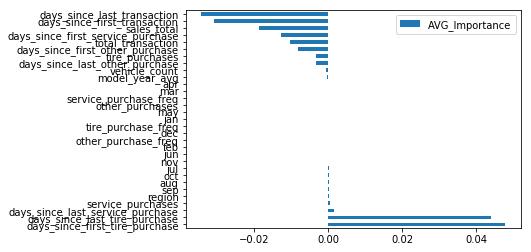

In [58]:
plt.show()